In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import seaborn as sns
cm = sns.color_palette(as_cmap=True)

## Simulation notes
For the simulation, the time is following this convention:
1 time unit = 10 ms


In [2]:
def epileptor(q, parameters):

	x1,y1,z,x2,y2,g = q
	a1, b1, c1, d1, tau, a2, c2, m, x0, r, s, Irest1, Irest2, Is1, Is2 =\
    parameters['a1'], parameters['b1'], parameters['c1'], parameters['d1'], parameters['tau'], \
    parameters['a2'], parameters['c2'], parameters['m'], parameters['x0'], parameters['r'], \
    parameters['s'], parameters['Irest1'], parameters['Irest2'], parameters['Is1'], parameters['Is2']
    
    ###################  Population 1 #################
	if x1 < 0:
		dx1 = y1  - a1 * (x1)**3  + b1 * (x1)**2 - z + Irest1 + Is1
	else:
		dx1 = y1 + (m -x2 + 0.6 * (z-4)**2)*x1- z + Irest1 + Is1
	dy1 = c1 - d1 * (x1)**2 - y1

	################## Population 2 ################### 
	dx2 = -y2 + x2 - (x2)**3 + Irest2 + 2*g - c2*(z-3.5) + Is2
	if x2 < -0.25:
		dy2 = 1./tau * (-y2)
	else:
		dy2 = 1./tau * (-y2 + a2 * (x2 + 0.25 ))
	dg = -0.01 * (g - 0.1*x1);

	################### Energy #####################"
	dz = r* (s * (x1 - x0) -z)
	#pdb.set_trace()
	return np.hstack((dx1, dy1, dz, dx2, dy2, dg))


Is1a = np.arange(0.1, 5.2, 0.05)
Is2a = np.arange(0.1, 10.2, 0.1)


llq = []
for Is1, Is2 in zip(Is1a, Is2a):
    print(Is1)
    print(Is2)

    # Parameters
    parameters = {'a1':1, 'b1':3, 'c1':1, 'd1':5,
                  'tau':10, 'a2':6, 'c2':0.3, 'm':0,
                  'x0':-2.25, 'r':0.00005, 's':4,
                  'Irest1':3.1, 'Irest2':0.45, 'Is1':0, 'Is2':0}

    # Find initial conditions by root solving
    q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
    q = fsolve(epileptor, q0, args=parameters)
    
    # sim parameters
    dt = 0.001
    t_sim_init = 200
    n_samples_init = int(t_sim_init/dt)
    t_sim = 2000
    n_samples = int(t_sim/dt)
    upsamp = 10
    t = np.linspace(0, t_sim, t_sim*upsamp)

    # stim parameters
    t_start = 25
    I_inter = 25.
    I_duration = .3
    n_stim = 1

    stim = 1
    parameters['Isa'], parameters['Is2'] = 0, 0
    for it in range(n_samples_init):
        # Runge-Kutta scheme
        p1 = epileptor(q, parameters)
        p2 = epileptor(q+(dt/2)*p1, parameters)
        p3 = epileptor(q+(dt/2)*p2, parameters)
        p4 = epileptor(q+(dt/2)*p3, parameters)
        q += dt/6 * (p1+2*p2+2*p3+p4)
       
    lq = []
    for it in range(n_samples):
        # if it%10000==0:
        #     print(it)
        tc = it*dt
        
        tstim = 0
        if stim:
            for i_stim in range(n_stim):
                if tc>=t_start + i_stim*I_duration + i_stim*I_inter and tc<t_start + (i_stim+1)*I_duration + i_stim*I_inter:
                    tstim = 1
        if tstim:
            parameters['Is1'] = Is1
            parameters['Is2'] = Is2
        else:
            parameters['Is1'] = 0
            parameters['Is2'] = 0
            
        # Runge-Kutta scheme
        p1 = epileptor(q, parameters)
        p2 = epileptor(q+(dt/2)*p1, parameters)
        p3 = epileptor(q+(dt/2)*p2, parameters)
        p4 = epileptor(q+(dt/2)*p3, parameters)
        q += dt/6 * (p1+2*p2+2*p3+p4)

        if it%int(1/(upsamp*dt))==0:
            lq.append(q.copy())
            
    llq.append(lq)
        
llq = np.array(llq)

0.1
0.1
0.15000000000000002
0.2
0.20000000000000004
0.30000000000000004
0.25000000000000006
0.4
0.30000000000000004
0.5
0.3500000000000001
0.6
0.40000000000000013
0.7000000000000001
0.45000000000000007
0.8
0.5000000000000001
0.9
0.5500000000000002
1.0
0.6000000000000002
1.1
0.6500000000000001
1.2000000000000002
0.7000000000000002
1.3000000000000003
0.7500000000000002
1.4000000000000001
0.8000000000000002
1.5000000000000002
0.8500000000000002
1.6
0.9000000000000002
1.7000000000000002
0.9500000000000003
1.8000000000000003
1.0000000000000004
1.9000000000000001
1.0500000000000003
2.0
1.1000000000000005
2.1
1.1500000000000004
2.2
1.2000000000000004
2.3000000000000003
1.2500000000000004
2.4000000000000004
1.3000000000000005
2.5000000000000004
1.3500000000000005
2.6
1.4000000000000006
2.7
1.4500000000000006
2.8000000000000003
1.5000000000000004
2.9000000000000004
1.5500000000000005
3.0000000000000004
1.6000000000000005
3.1
1.6500000000000006
3.2
1.7000000000000006
3.3000000000000003
1.7500000

In [3]:
# llq: (#stim, time, #variables)
llq.shape

(101, 20000, 6)

### Time series

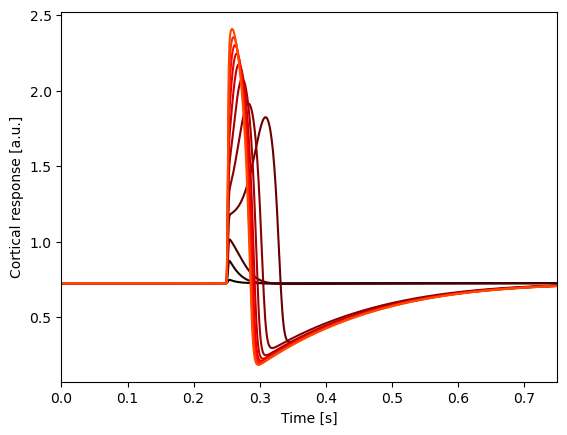

In [5]:
ts = -llq[::5, :, 0] + llq[::5, :, 3]
plt.figure()
cm = plt.colormaps['hot'](np.linspace(0.0, 1.0, 2*len(Is2a[:51:5])))[:, :3]
for iIs2, Is2 in enumerate(Is2a[:51:5]):
    # time in seconds
    plt.plot(t/100, ts[iIs2], color=cm[iIs2])
plt.xlim([0., .75])
plt.xlabel('Time [s]')
plt.ylabel('Cortical response [a.u.]')
plt.savefig('figures/single_stim_time_series.svg')

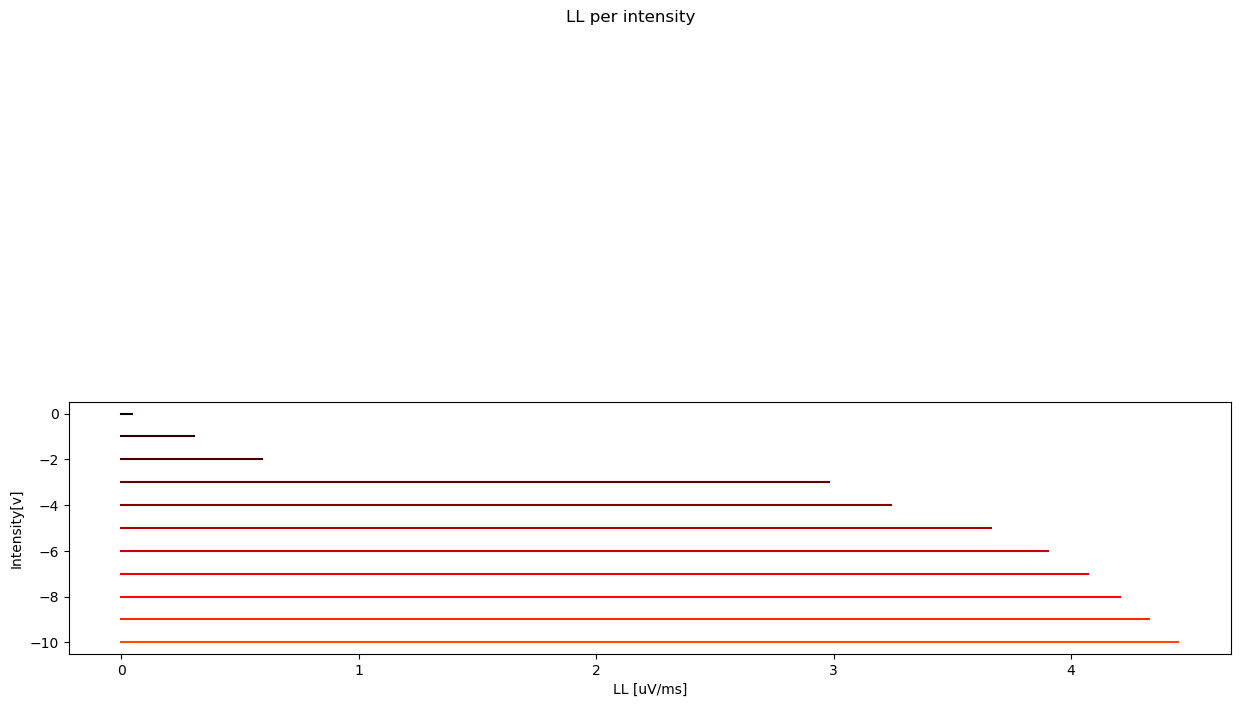

In [19]:
title = "LL per intensity"
fig2 = plt.figure(title, figsize=(15, 8)).suptitle(title)
ax1 = plt.subplot2grid((12, 12), (6, 0), rowspan=5, colspan=12)
# for i in range(len(all_diff_intensity)):
cm = plt.colormaps['hot'](np.linspace(0.0, 1.0, 2*len(Is2a[:51:5])))[:, :3]

for iIs2, Is2 in enumerate(Is2a[:51:5]):
    # Mean_EEG = Mean_EEG_by_intensity[i]
    Sum_LL = np.sum(np.abs(np.diff(ts[iIs2])))
    ax1.plot([0, Sum_LL], [-iIs2, -iIs2], color=cm[iIs2], label=str(iIs2) + ' [V]')
ax1.set_xlabel("LL [uV/ms]")
ax1.set_ylabel("Intensity[v]")
plt.savefig('figures/bars.svg')

### Phase space

5.1


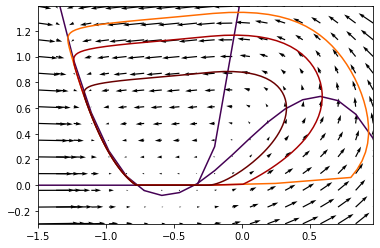

In [55]:
def pop2(x2, y2, z, g, parameters):
    
    a1, b1, c1, d1, tau, a2, c2, m, x0, r, s, Irest1, Irest2, Is1, Is2 =\
    parameters['a1'], parameters['b1'], parameters['c1'], parameters['d1'], parameters['tau'], \
    parameters['a2'], parameters['c2'], parameters['m'], parameters['x0'], parameters['r'], \
    parameters['s'], parameters['Irest1'], parameters['Irest2'], parameters['Is1'], parameters['Is2']
        
    dx2 = -y2 + x2 - (x2)**3 + Irest2 + 2*g - c2*(z-3.5) + Is2
    dy2 = np.where(x2 < -0.25, 1./tau * (-y2), 1./tau * (-y2 + a2 * (x2 + 0.25 )))
    return (dx2, dy2)
        
parameters = {'a1':1, 'b1':3, 'c1':1, 'd1':5,
              'tau':10, 'a2':6, 'c2':0.3, 'm':0,
              'x0':-2.25, 'r':0.00005, 's':4,
              'Irest1':3.1, 'Irest2':0.45, 'Is1':0, 'Is2':0}

q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
q = fsolve(epileptor, q0, args=parameters)
z = q[2]
g = q[5]

x2r = np.arange(-1.5, 1.1, .13)
y2r = np.arange(-.3, 1.5, .13)

x2, y2 = np.meshgrid(x2r, y2r)
     
(x2d, y2d) = pop2(x2, y2, z, g, parameters)

print(Is2a[50])
plt.figure()
plt.quiver(x2, y2, x2d, y2d)
plt.contour(x2, y2, x2d, [0])
plt.contour(x2, y2, y2d, [0])
plt.plot(llq[49, :, 3], llq[49, :, 4], color=cm[11])
plt.plot(llq[25, :, 3], llq[25, :, 4], color=cm[5])
plt.plot(llq[15, :, 3], llq[15, :, 4], color=cm[3])
plt.savefig('figures/phase_space_pop2.svg')

(11, 20000)


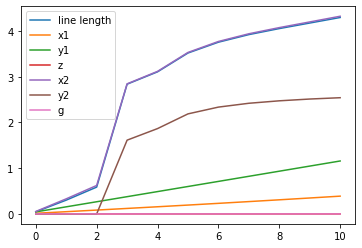

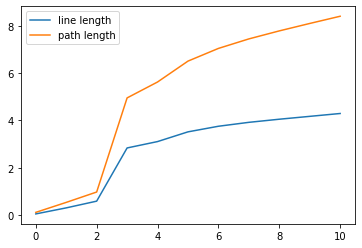

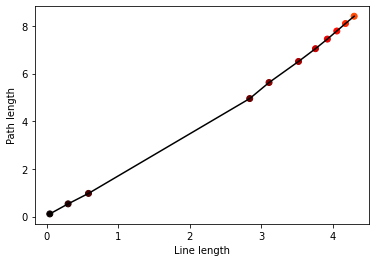

In [41]:
ts = -llq[:51:5, :, 0] + llq[:51:5, :, 3]
print(ts.shape)

t_stim_onsets= []
for iIs2 in range(ts.shape[0]):
    tc = (t_start + i_stim*I_duration + i_stim*I_inter)*upsamp
    t_stim_onsets.append(tc)

dif = []
for iIs2 in range(ts.shape[0]):
    dif.append(np.sum(np.abs(np.diff(ts[iIs2, int(t_stim_onsets[iIs2]):int((t_stim_onsets[iIs2]+25*upsamp))]))))

dif_6d = []
for iIs2 in range(ts.shape[0]):
    for idim in range(6):
        qc = llq[::5][iIs2, int(t_stim_onsets[iIs2]):int(t_stim_onsets[iIs2]+25*upsamp), idim]
        dif_6d.append(np.sum(np.abs(np.diff(qc))))

dif_6dr = np.reshape(dif_6d, (11, 6))

plt.figure()
plt.plot(dif, label='line length')
plt.plot(dif_6dr, label=['x1', 'y1', 'z', 'x2', 'y2', 'g'])
plt.legend()
# plt.xticks(range(len(dif)), np.round(lx0, 2))
plt.savefig('figures/line_length_path_length_all_ts.svg')

plt.figure()
plt.plot(dif, label='line length')
plt.plot(np.sum(dif_6dr, 1), label='path length')
plt.legend()
# plt.xticks(range(len(dif)), np.round(lx0, 2))
plt.savefig('figures/line_length_path_length_sum6d_ts.svg')
         
cm = plt.colormaps['hot'](np.linspace(0.0, 1.0, 2*len(Is2a[:51:5])))[:, :3]
plt.figure()
plt.scatter(dif, np.sum(dif_6dr, 1), c=cm[:-11])
plt.plot(dif, np.sum(dif_6dr, 1), color='k')
plt.xlabel('Line length')
plt.ylabel('Path length')
plt.savefig('figures/line_length_path_length_scatter.svg')